In [19]:
"""
This notebook runs a C/O=1.0 simulation at the experimental temperature profile

Reactor conditions are replicated from: "Methane catalytic partial oxidation on
autothermal Rh and Pt foam catalysts: Oxidation and reforming zones, transport
effects,and approach to thermodynamic equilibrium"
Horn 2007, doi:10.1016/j.jcat.2007.05.011

Ref 17: "Syngas by catalytic partial oxidation of methane on rhodium:
Mechanistic conclusions from spatially resolved measurements and numerical
simulations"
Horn 2006, doi:10.1016/j.jcat.2006.05.008

Ref 18: "Spatial and temporal profiles in millisecond partial oxidation
processes"
Horn 2006, doi:10.1007/s10562-006-0117-8
"""

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
import pylab
from cycler import cycler
import seaborn as sns
import os
%matplotlib inline

# this chemkin file is from the cti generated by rmg
# i only need to import it once
gas = ct.Solution('../cantera/chem_annotated.cti','gas')
surf = ct.Interface('../cantera/chem_annotated.cti','surface1', [gas])

i_ar = gas.species_index('Ar')

# unit conversion factors to SI
mm = 0.001
cm = 0.01
ms = mm
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################
length = 25 * mm  # Reactor length - catalyst length 10mm, but it doesn't say where.  let's guess at 1 cm?
diam = 16.5*mm  # Reactor diameter - in m
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube) in m^2
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000  # m2/m3, which is 160 cm2/cm3, as used in Horn 2006
flow_rate = 4.7  # slpm, as seen in as seen in doi:10.1016/j.jcat.2007.05.011, Horn 2007
flow_rate = flow_rate*.001/60  # m^3/s, as seen in as seen in doi:10.1016/j.jcat.2007.05.011, Horn 2007
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate/area  # m/s

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2501

on_catalyst = 1000  # catalyst length 10mm
off_catalyst = 2000
dt = 1.0

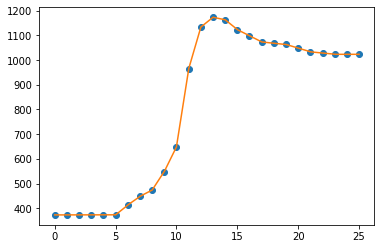

In [43]:
temp_profile = np.array([ # [reactor location (mm), temperature (K)]
        [0.,373.15],
        [1.,373.15],
        [2.,373.15],
        [3.,373.15],
        [4.,373.15],
        [5.,373.15],
        [6.,413.15],
        [7.,448.15],
        [8.,473.15],
        [9.,548.15],
        [10.,648.15],
        [11.,963.15],
        [12.,1133.15],
        [13.,1173.15],
        [14.,1163.15],
        [15.,1123.15],
        [16.,1098.15],
        [17.,1073.15],
        [18.,1068.15],
        [19.,1063.15],
        [20.,1048.15],
        [21.,1033.15],
        [22.,1028.15],
        [23.,1023.15],
        [24.,1023.15],
        [25.,1023.15],])

x = temp_profile[:,0]
y = temp_profile[:,1]

# more refined temp profile
a = np.linspace(0,25,2501)
q = []
for k in range(len(y)-1):
    if k <= len(y)-3:
        p = (np.linspace(y[k],y[k+1],100,endpoint=False))
    else:
        p = (np.linspace(y[k],y[k+1],101))
    q.append(p.tolist())
b = [item for sublist in q for item in sublist]

plt.plot(x,y,'o')
plt.plot(a,b)
temp_array = b
plt.show()

In [56]:
def monolithFull(gas,surf,temp,mol_in,verbose=False,sens=False):
    """
    Verbose prints out values as you go along
    Sens is for sensitivity, in the form [perturbation, reaction #]
    """
    T_prof = temp
    
    ch4,o2,ar = mol_in
    ch4=str(ch4);o2=str(o2);ar=str(ar)
    X = str('CH4(2):'+ch4+', O2(3):'+o2+', Ar:'+ar)
    gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
    # mass_flow_rate = velocity * gas.density_mass * area  # kg/s
    mass_flow_rate = flow_rate * gas.density_mass
    gas.TPX = T_prof[0], ct.one_atm, X
    surf.TP = T_prof[0], ct.one_atm
    surf.coverages = 'X(1):1.0'
    gas.set_multiplier(1.0)
    
    TDY = gas.TDY
    cov = surf.coverages

    if verbose is True:
        print('  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas)
    r.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream = ct.Reservoir(gas, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream = ct.Reservoir(gas, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-18

    gas_names = gas.species_names
    surf_names = surf.species_names
    gas_out = [] # in mol fractions
    surf_out = []
    dist_array=[]
    T_array = []


    surf.set_multiplier(0.0) #no surface reactions until the gauze
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY =  T_prof[n],r.thermo.TDY[1],r.thermo.TDY[2]
        upstream.syncState()
        if n==on_catalyst:
            surf.set_multiplier(1.0)
            if sens is not False:
                surf.set_multiplier(1.0+sens[0],sens[1])
        if n==off_catalyst:
            surf.set_multiplier(0.0)
        # Integrate the reactor forward in time until steady state has been reached
        sim.reinitialize()
        sim.advance_to_steady_state()
        
        dist = n * reactor_len * 1.0e3   # distance in mm
        dist_array.append(dist)
        T_array.append(surf.T)
        gas_out.append(gas.X.copy())
        surf_out.append(surf.X.copy())
        
        # make reaction diagrams
#         out_dir = 'fixed-temp/rxnpath'
#         os.path.exists(out_dir) or os.makedirs(out_dir)
#         elements = ['H', 'O']
#         locations_of_interest = [1000,1100,1200,1300,1999]
#         for l in locations_of_interest:
#             if n==l:
#                 location = str(int(n/100))

#                 diagram = ct.ReactionPathDiagram(surf,'X')
#                 diagram.title = 'rxn path'
#                 diagram.label_threshold = 1e-9
#                 dot_file = 'rxnpath-ft-x-' + location + 'mm' + '.dot'
#                 img_file = 'rxnpath-ft-x-' + location + 'mm' + '.png'
#                 img_path = os.path.join(os.getcwd(), img_file)
#                 diagram.write_dot(dot_file)
#                 os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
#                   
#                 for element in elements:
#                     diagram = ct.ReactionPathDiagram(gas,element)
#                     diagram.title = element + 'rxn path'
#                     diagram.label_threshold = 1e-9
#                     dot_file = 'rxnpath-ft-gas-' + location + 'mm-' + element + '.dot'
#                     img_file = 'rxnpath-ft-gas-' + location + 'mm-' + element + '.png'
#                     img_path = os.path.join(os.getcwd(), img_file)
#                     diagram.write_dot(dot_file)
#                     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
#                     
#                     diagram = ct.ReactionPathDiagram(surf,element)
#                     diagram.title = element + 'rxn path'
#                     diagram.label_threshold = 1e-9
#                     dot_file = 'rxnpath-ft-surf-' + location + 'mm-' + element + '.dot'
#                     img_file = 'rxnpath-ft-surf-' + location + 'mm-' + element + '.png'
#                     img_path = os.path.join(os.getcwd(), img_file)
#                     diagram.write_dot(dot_file)
#                     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas['CH4(2)','O2(3)','H2(6)','CO(7)','H2O(5)','CO2(4)'].X))
                #print(surf.T)
                #print(gas.P)
                #print(surf.coverages)

    gas_out = np.array(gas_out)
    surf_out = np.array(surf_out)
    gas_names = np.array(gas_names)
    surf_names = np.array(surf_names)
    return gas_out, surf_out, gas_names, surf_names, dist_array, T_array

In [45]:
def plotflow(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
    gas_out = gas_out * .208
    
    # Plot in mol/min
    
    # configure the plot
    fig, axs = plt.subplots(1,2)

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))                          

    #PLOT WITH GAS PHASE REACTIONS INCLUDED
    for i in range(len(gas_out[0,:])):
        if i != i_ar:
            if gas_out[:,i].max() > 5.e-3:
    #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                                if species_name[-3] == '(':
                                    species_name = species_name[0:-3]
                                else:
                                    species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/100.0), va =('bottom'), ha = ('center'))
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/10.0), va =('top'), ha = ('center'))
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+0.001), va =('bottom'), ha = ('center'))
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+0.001), va =('bottom'), ha = ('center'))    
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/100.0), va =('bottom'), ha = ('center'))  
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/40.0), va =('top'), ha = ('center'))   
                else:                     
                    axs[0].annotate(species_name, fontsize=12, xy=(dist_array[1800], gas_out[:,i][-1]+gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
            else:
                axs[0].plot(0,0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
    axs[1].plot(dist_array, T_array, label="surface + gas reactions")

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))   

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[0,0.3], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[0,0.3], linestyle='--', color='xkcd:grey')  
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.075), va =('bottom'), ha = ('left'))
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[400.0,1300], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[400.0,1300], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1005), va =('bottom'), ha = ('left'))

    for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0.,0.1); axs[1].set_ylim(200.0,1300)
    axs[0].set_xlim(0.0,length/mm); axs[1].set_xlim(0.0,length/mm)
    axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
    fig.set_figheight(6)
    fig.set_figwidth(18)
    
    temperature = np.round(T_array[0],0)
    
    for n in range(len(gas_names)):
        if gas_names[n]=='CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n]=='O2(3)':
            o_in = gas_out[0][n]
    ratio = round(c_in/(o_in*2),1)
    # uncomment to save figure
    fig.savefig('fixed-temp-' + str(ratio)+ 'ratio.pdf', bbox_inches='tight')

def plotSurf(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

    fig, axs = plt.subplots(1, 2)
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    for i in range(len(gas_out[0, :])):
        if i != i_ar:
            if gas_out[:, i].max() > 5.e-3:
                #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:, i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                    if species_name[-3] == '(':
                        species_name = species_name[0:-3]
                    else:
                        species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 10.0), va='top',
                                    ha='center')
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 40.0), va='top',
                                    ha='center')
                else:
                    axs[0].annotate(species_name, fontsize=12,
                                    xy=(dist_array[-1], gas_out[:, i][-1] + gas_out[:, i][-1] / 10.0), va='top',
                                    ha='center')
            else:
                axs[0].plot(0, 0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))
    # Plot two temperatures (of gas-phase and surface vs only surface.)
    for i in range(len(surf_out[0, :])):
        if surf_out[:, i].max() > 5.e-6:
            axs[1].semilogy(dist_array, surf_out[:, i], label=surf_names[i])
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va='bottom', ha='left')
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1.1), va='bottom', ha='left')

    for item in (
            axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0., 0.1)
    axs[1].set_ylim(1e-10, 1.2)  # change back to 1.2
    axs[0].set_xlim(5, 25)
    axs[1].set_xlim(5, 25)
    axs[0].set_xlabel('Distance (mm)', fontsize=13)
    axs[1].set_xlabel('Distance (mm)', fontsize=13)  # axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13)
    axs[1].set_ylabel('Site fraction', fontsize=13)
    # fig.tight_layout()
    # axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.delaxes(axs[0])  # THIS DELETES THE EXTRA SUBPLOT!

    fig.set_figheight(6)
    fig.set_figwidth(18)

    #     temperature = np.round(T_array[0],0)
#     for n in range(len(gas_names)):
#         if gas_names[n] == 'CH4(2)':
#             c_in = gas_out[0][n]
#         if gas_names[n] == 'O2(3)':
#             o_in = gas_out[0][n]
#     ratio = c_in / (o_in * 2)
#     ratio = round(ratio, 1)

#     out_dir = 'figures'
#     os.path.exists(out_dir) or os.makedirs(out_dir)
#     fig.savefig(out_dir + '/' + str(ratio) + 'surf.png', bbox_inches='tight')

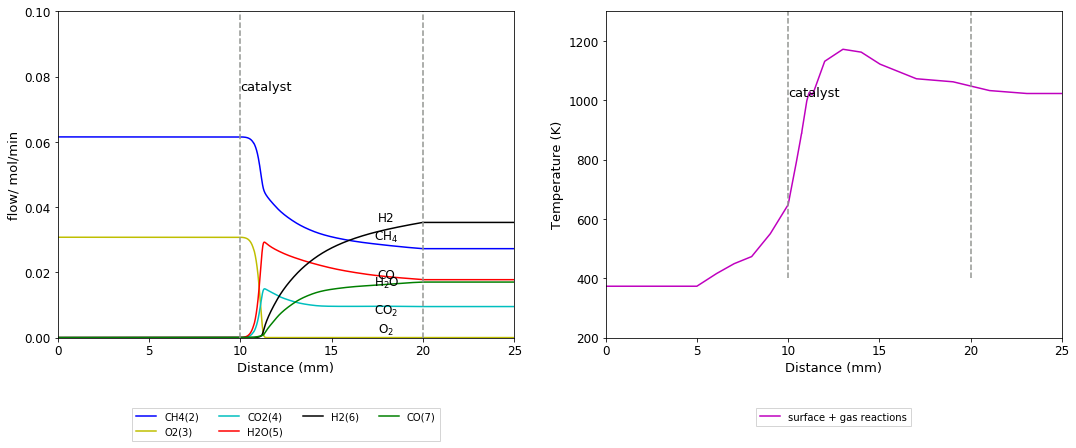

In [46]:
r = 1.0
fo2 = 0.208/(2.*r+1+79/21)
fch4 = 2*fo2*r
far = 79*fo2/21

moles_in = [fch4,fo2,far]

a = monolithFull(gas,surf,temp_array,moles_in)
plotflow(a)

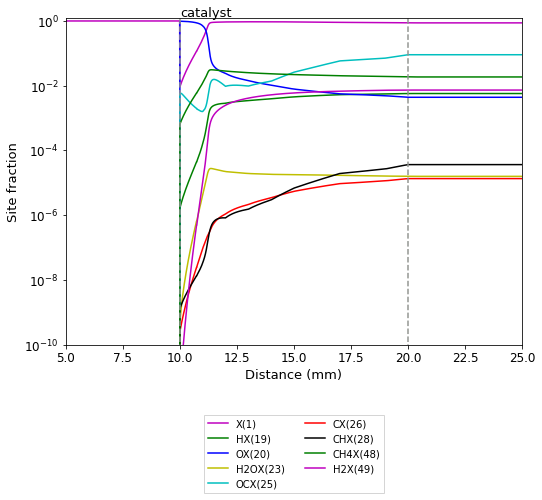

In [47]:
plotSurf(a)

In [48]:
# data taken from plots in Reactor conditions are replicated from: "Methane catalytic partial oxidation on
# autothermal Rh and Pt foam catalysts: Oxidation and reforming zones, transport
# effects,and approach to thermodynamic equilibrium"
# Horn 2007, doi:10.1016/j.jcat.2007.05.011

ch4_in = 21/71*.208
ch4_profile = np.array([
        [0.,ch4_in],
        [1.,ch4_in],
        [2.,ch4_in],
        [3.,ch4_in],
        [4.,ch4_in],
        [5.,ch4_in],
        [6.,ch4_in],
        [7.,ch4_in],
        [8.,ch4_in],
        [9.,ch4_in],
        [10.,ch4_in],
        [10.25,0.059],
        [10.5,0.048],
        [10.75,0.041],
        [11.,0.036],
        [11.5,0.028],
        [12.,0.0225],
        [12.25,0.022],
        [12.5,0.021],
        [13.,0.021],
        [13.5,0.022],
        [14.,0.022],
        [14.5,0.021],
        [15.,0.019],
        [15.5,0.017],
        [16.,0.016],
        [17.,0.016],
        [18.,0.015],
        [19.,0.015],
        [20.,0.015],
        [21.,0.014],
        [22.,0.014],
        [23.,0.014],
        [24.,0.014],
        [25.,0.014],])

o2_in = (1 / (2. + 1 + 79 / 21)) * .208
o2_profile = np.array([
        [0.,o2_in],
        [1.,o2_in],
        [2.,o2_in],
        [3.,o2_in],
        [4.,o2_in],
        [5.,o2_in],
        [6.,o2_in],
        [7.,o2_in],
        [8.,o2_in],
        [9.,o2_in],
        [9.5,o2_in],
        [9.75,o2_in],
        [10.,o2_in],
        [10.1,0.028],
        [10.25,0.022],
        [10.5,0.013],
        [10.75,0.008],
        [11.,0.004],
        [11.25,0.001],
        [11.5,0.],
        [12.,0.],
        [13.,0.],
        [14.,0.],
        [15.,0.],
        [16.,0.],
        [17.,0.],
        [18.,0.],
        [19.,0.],
        [20.,0.],
        [21.,0.],
        [22.,0.],
        [23.,0.],
        [24.,0.],
        [25.,0.],])

h2_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.034],
        [12.,0.051],
        [13.,0.065],
        [14.,0.071],
        [15.,0.083],
        [16.,0.089],
        [17.,0.0895],
        [18.,0.09],
        [19.,0.0905],
        [20.,0.091],
        [21.,0.092],
        [22.,0.092],
        [23.,0.092],
        [24.,0.092],
        [25.,0.092],])

co_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.026],
        [12.,0.035],
        [13.,0.04],
        [14.,0.036],
        [15.,0.04],
        [16.,0.044],
        [17.,0.045],
        [18.,0.045],
        [19.,0.045],
        [20.,0.045],
        [21.,0.045],
        [22.,0.045],
        [23.,0.045],
        [24.,0.045],
        [25.,0.045],])

h2o_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.025],
        [11.5,0.026],
        [12.,0.025],
        [12.5,0.022],
        [13.,0.019],
        [14.,0.011],
        [15.,0.009],
        [16.,0.009],
        [17.,0.009],
        [18.,0.008],
        [19.,0.008],
        [20.,0.008],
        [21.,0.008],
        [22.,0.008],
        [23.,0.008],
        [24.,0.008],
        [25.,0.008],])

co2_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [11.,0.002],
        [12.,0.002],
        [12.5,0.002],
        [13.,0.002],
        [14.,0.002],
        [15.,0.002],
        [16.,0.002],
        [17.,0.002],
        [18.,0.002],
        [19.,0.002],
        [20.,0.002],
        [21.,0.002],
        [22.,0.002],
        [23.,0.002],
        [24.,0.002],
        [25.,0.002],])

In [49]:
from scipy.interpolate import interp1d

dist = np.linspace(0,25,2501)
ch4 = interp1d(ch4_profile[:,0],ch4_profile[:,1],kind='cubic')
o2 = interp1d(o2_profile[:,0],o2_profile[:,1],kind='cubic')
h2 = interp1d(h2_profile[:,0],h2_profile[:,1],kind='cubic')
co = interp1d(co_profile[:,0],co_profile[:,1],kind='cubic')
h2o = interp1d(h2o_profile[:,0],h2o_profile[:,1],kind='cubic')
co2 = interp1d(co2_profile[:,0],co2_profile[:,1],kind='cubic')
temp = interp1d(temp_profile[:,0],temp_profile[:,1],kind='cubic')

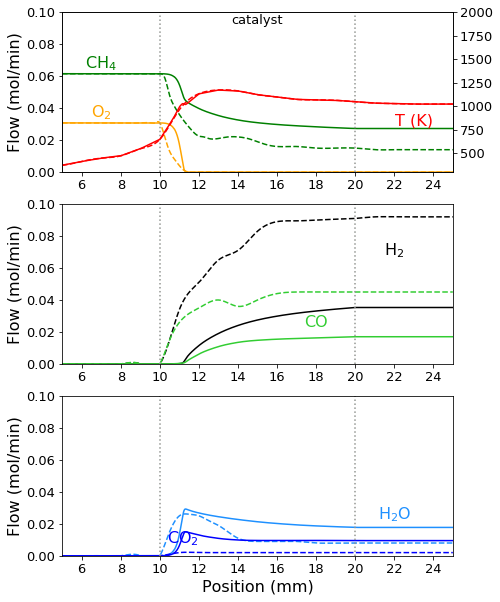

In [53]:
gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
gas_out = gas_out * .208
fig, axs = plt.subplots(3, 1)

# plotting ch4
axs[0].plot(dist_array,gas_out[:,3], label=gas_names[3],color='g')
axs[0].annotate("CH$_4$", fontsize=16, color='g',
            xy=(dist_array[700], gas_out[:, 3][500] + gas_out[:, 3][500] / 100.0),
            va='bottom', ha='center')
axs[0].plot(dist,ch4(dist),'--',color='g')
# plotting o2
axs[0].plot(dist_array,gas_out[:,4], label=gas_names[4],color='orange')
axs[0].annotate("O$_2$", fontsize=16, color='orange',
            xy=(dist_array[700], gas_out[:, 4][500] + gas_out[:, 4][500] / 100.0),
            va='bottom', ha='center')
axs[0].plot(dist,o2(dist),'--',color='orange')

axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[1500], 0.095), va='center', ha='center')

axs[0].set_ylabel('Flow (mol/min)', fontsize=16)
axs[0].set_ylim((0,0.1))
for item in (axs[0].get_xticklabels()):
             item.set_fontsize(13)
for item in (axs[0].get_yticklabels()):
             item.set_fontsize(13)
axs[0].set_xticks(np.arange(6,26,2))

ax2 = axs[0].twinx()
ax2.plot(dist,temp(dist), '--', color='r')
ax2.plot(dist_array,T_array,color='r')
ax2.annotate("T (K)",fontsize=16, color='r',
             xy=(dist_array[2300], T_array[2300] -100),
             va='top', ha='center')
ax2.set_ylim(300, 2000)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(13)
axs[0].set_xlim((5,25))

# plotting h2
axs[1].plot(dist_array,gas_out[:,7], label=gas_names[7],color='k')
axs[1].annotate("H$_2$", fontsize=16, color='k',
            xy=(dist_array[2200], 0.065),
            va='bottom', ha='center')
axs[1].plot(dist,h2(dist),'--',color='k')
# plotting co
axs[1].plot(dist_array,gas_out[:,8], label=gas_names[8],color='limegreen')
axs[1].annotate("CO", fontsize=16, color='limegreen',
            xy=(dist_array[1800], gas_out[:, 8][1800] + gas_out[:, 8][1800] / 100.0 + 0.005),
            va='bottom', ha='center')
axs[1].plot(dist,co(dist),'--',color='limegreen')

axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')

axs[1].set_ylabel('Flow (mol/min)', fontsize=16)
axs[1].set_ylim((0,0.1))
for item in (axs[1].get_xticklabels()):
             item.set_fontsize(13)
for item in (axs[1].get_yticklabels()):
             item.set_fontsize(13)
axs[1].set_xticks(np.arange(6,26,2))

axs[1].set_xlim((5,25))  # cutting off where the horn paper cuts off the plots

# plotting h2o
axs[2].plot(dist_array,gas_out[:,6], label=gas_names[6],color='dodgerblue')
axs[2].annotate("H$_2$O", fontsize=16, color='dodgerblue',
            xy=(dist_array[2200], 0.02),
            va='bottom', ha='center')
axs[2].plot(dist,h2o(dist),'--',color='dodgerblue')
# plotting co2
axs[2].plot(dist_array,gas_out[:,5], label=gas_names[5],color='blue')
axs[2].annotate("CO$_2$", fontsize=16, color='blue',
            xy=(dist_array[1120], .005),
            va='bottom', ha='center')
axs[2].plot(dist,co2(dist),'--',color='blue')

axs[2].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[2].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')

axs[2].set_ylabel('Flow (mol/min)', fontsize=16)
axs[2].set_ylim((0,0.1))
for item in (axs[2].get_xticklabels()):
             item.set_fontsize(13)
for item in (axs[2].get_yticklabels()):
             item.set_fontsize(13)
axs[2].set_xticks(np.arange(6,26,2))

axs[2].set_xlim((5,25))  # cutting off where the horn paper cuts off the plots

axs[2].set_xlabel('Position (mm)', fontsize=16)
fig.set_figheight(10)
fig.set_figwidth(7)
plt.savefig('./paperplots/all_compare_subplots_ft_Rh.pdf',bbox_inches='tight',dpi=300)
# plt.show()